In [1]:
# imports

import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product

In [2]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\l0ki4\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Работа с данными

Объеденим данные по месяцам:

In [3]:
eff_train = pd.read_csv('data/eff_train/eff_train1.csv', sep=';')
for x in range(2,11):
    eff_train_new = pd.read_csv('data/eff_train/eff_train{}.csv'.format(x), sep=';')
    eff_train = pd.concat([eff_train, eff_train_new])
eff_train = eff_train.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_train.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good


In [4]:
eff_test1 = pd.read_csv('data/eff_test/eff_test1.csv', sep=';')
eff_test2 = pd.read_csv('data/eff_test/eff_test2.csv', sep=';')
eff_test = pd.concat([eff_test1, eff_test2])
eff_test = eff_test.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_test.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.08.2017 0:00,16836.91,Good
1,Efficiency,01.08.2017 0:00,17145.51,Good


In [5]:
energy_train = pd.read_csv('data/energy_cons_train/Energy_cons_train1.csv', sep=';')
for x in range(2,11):
    energy_train_new = pd.read_csv('data/energy_cons_train/Energy_cons_train{}.csv'.format(x), sep=';')
    energy_train = pd.concat([energy_train, energy_train_new])
energy_train = energy_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_train.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.10.2016 0:01,20.347508,Good
1,Energy_cons,01.10.2016 0:02,20.24238,Good


In [6]:
energy_test = pd.read_csv('data/energy_cons_test/Energy_cons_test1.csv', sep=';')
x=2
energy_test_new = pd.read_csv('data/energy_cons_test/Energy_cons_test{}.csv'.format(x), sep=';')
energy_test = pd.concat([energy_test, energy_test_new])
energy_test = energy_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_test.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.08.2017 0:01,17.324733,Good
1,Energy_cons,01.08.2017 0:02,17.46305,Good


In [7]:
qual_train = pd.read_csv('data/qual_train/qual_train1.csv', sep=';') 
for x in range(2,11): 
    qual_train_new = pd.read_csv('data/qual_train/qual_train{}.csv'.format(x), sep=';') 
    qual_train = pd.concat([qual_train, qual_train_new]) 
qual_train = qual_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_train.head(2)

,tag,timestamp,value,quality
0,Quality,01.10.2016 0:38,2.2,Good
1,Quality,01.10.2016 1:02,2.2,Good


In [8]:
qual_test = pd.read_csv('data/qual_test/qual_test1.csv', sep=';') 
x=2 
qual_test_new = pd.read_csv('data/qual_test/qual_test{}.csv'.format(x), sep=';') 
qual_test = pd.concat([qual_test, qual_test_new]) 
qual_test = qual_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_test.head(2)

,tag,timestamp,value,quality
0,Quality,01.08.2017 0:14,2.2,Good
1,Quality,01.08.2017 0:38,2.2,Good


# Объеденим трэйн и тест:

In [9]:
eff_all = pd.concat([eff_train, eff_test])
qual_all = pd.concat([qual_train, qual_test])
energy_all = pd.concat([energy_train, energy_test])

# преобразуем колонку timestamp в тип datetime:

In [10]:
eff_all["timestamp"] = pd.to_datetime(eff_all["timestamp"], format = '%d.%m.%Y %H:%M')
qual_all["timestamp"] = pd.to_datetime(qual_all["timestamp"], format = '%d.%m.%Y %H:%M')
energy_all["timestamp"] = pd.to_datetime(energy_all["timestamp"], format = '%d.%m.%Y %H:%M')

In [11]:
eff_all.head()

,tag,timestamp,value,quality
0,Efficiency,2016-10-01,16137.70,Good
1,Efficiency,2016-10-01,16060.55,Good
2,Efficiency,2016-10-01,16633.79,Good
3,Efficiency,2016-10-01,17578.13,Good
4,Efficiency,2016-10-01,17331.05,Good


In [12]:
qual_all.head()

,tag,timestamp,value,quality
0,Quality,2016-10-01 00:38:00,2.2,Good
1,Quality,2016-10-01 01:02:00,2.2,Good
2,Quality,2016-10-01 01:26:00,2.3,Good
3,Quality,2016-10-01 01:50:00,2.2,Good
4,Quality,2016-10-01 02:14:00,2.2,Good


In [13]:
energy_all.head()

,tag,timestamp,value,quality
0,Energy_cons,2016-10-01 00:01:00,20.347508,Good
1,Energy_cons,2016-10-01 00:02:00,20.24238,Good
2,Energy_cons,2016-10-01 00:03:00,20.208391,Good
3,Energy_cons,2016-10-01 00:04:00,20.239189,Good
4,Energy_cons,2016-10-01 00:05:00,20.262808,Good


# Уберем мусор в данных:

In [14]:
energy_all["value"] = pd.to_numeric(energy_all["value"], downcast = 'float', errors='coerse')
energy_all = energy_all[energy_all["value"].notnull()]

In [15]:
energy_all = energy_all[energy_all["quality"] == "Good"]
qual_all = qual_all[qual_all["quality"] == "Good"]
eff_all = eff_all[eff_all["quality"] == "Good"]
eff_all = eff_all[eff_all["value"] > 0.0]
qual_all = qual_all[qual_all["value"] > 0.0]
energy_all = energy_all[energy_all["value"] > 0.0]

# Визуализируем данные

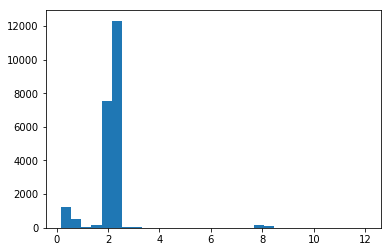

In [16]:
plt.hist(qual_all["value"], 30)
plt.show()

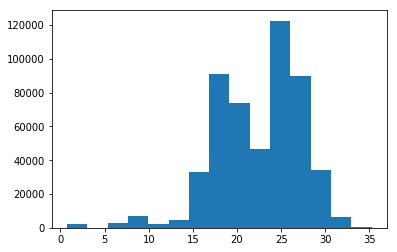

In [17]:
plt.hist(energy_all["value"], 15)
plt.show()

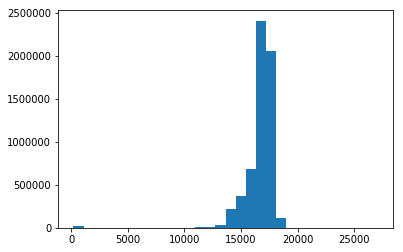

In [18]:
plt.hist(eff_all["value"], 30)
plt.show()

In [19]:
energy_all['timestamp'].values

array(['2016-10-01T00:01:00.000000000', '2016-10-01T00:02:00.000000000',
       '2016-10-01T00:03:00.000000000', ...,
       '2017-09-30T23:14:00.000000000', '2017-09-30T23:16:00.000000000',
       '2017-09-30T23:17:00.000000000'], dtype='datetime64[ns]')

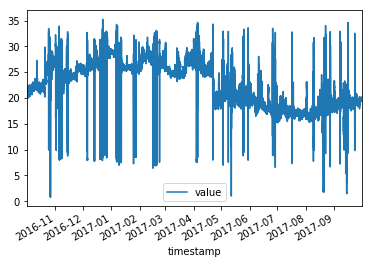

In [20]:
energy_all.plot(x = 'timestamp', y = 'value')


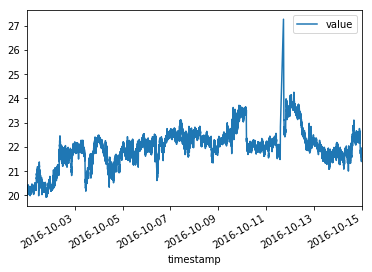

In [21]:
energy_lol = energy_all[energy_all['timestamp'] > '2016-10-01T00:01:00.000000000']
energy_lol = energy_lol[energy_lol['timestamp'] < '2016-10-15T00:01:00.000000000']
energy_lol.head()

energy_lol.plot(x = 'timestamp', y = 'value')

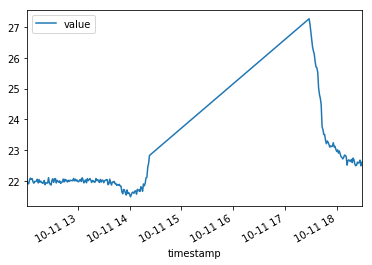

In [22]:
energy_lol = energy_all[energy_all['timestamp'] > '2016-10-11T12:00:00.000000000']
energy_lol = energy_lol[energy_lol['timestamp'] < '2016-10-11T18:30:00.000000000']
energy_lol.head()

energy_lol.plot(x = 'timestamp', y = 'value')

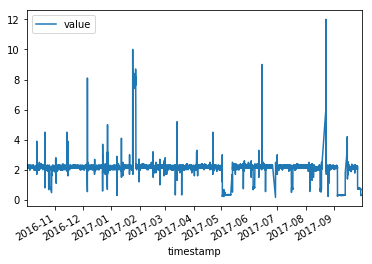

In [23]:
qual_all.plot(x = 'timestamp', y = 'value')

In [24]:
eff_all.shape

(5920437, 4)

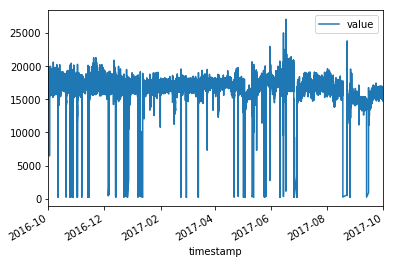

In [25]:
eff_all.plot(x = 'timestamp', y = 'value')

In [26]:
qual_all.head()

,tag,timestamp,value,quality
0,Quality,2016-10-01 00:38:00,2.2,Good
1,Quality,2016-10-01 01:02:00,2.2,Good
2,Quality,2016-10-01 01:26:00,2.3,Good
3,Quality,2016-10-01 01:50:00,2.2,Good
4,Quality,2016-10-01 02:14:00,2.2,Good


# Попробуем метод из HW0 DMIA_Sport
## есть два варианта попробовать создать сетку -- grid со всеми признаками замерджиными по дате, места где нет пересечений занулить или работать с каждым отдельно, попробую второй так как он быстрее, надеюсь что кто-то из вас попробует первый вариант на effeciency и quality (Вроде бы Саня выяснил, что они зависимы)

# Работаю с energy

In [19]:
energy_all['timestamp'].values

array(['2016-10-01T00:01:00.000000000', '2016-10-01T00:02:00.000000000',
       '2016-10-01T00:03:00.000000000', ...,
       '2017-09-30T23:14:00.000000000', '2017-09-30T23:16:00.000000000',
       '2017-09-30T23:17:00.000000000'], dtype='datetime64[ns]')

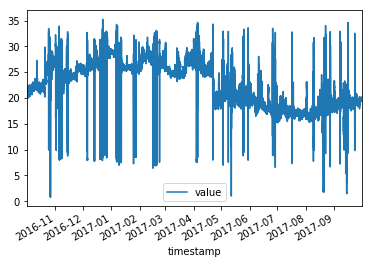

In [20]:
energy_all.plot(x = 'timestamp', y = 'value')


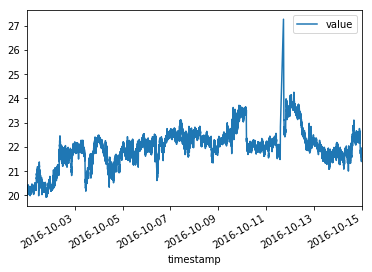

In [21]:
energy_lol = energy_all[energy_all['timestamp'] > '2016-10-01T00:01:00.000000000']
energy_lol = energy_lol[energy_lol['timestamp'] < '2016-10-15T00:01:00.000000000']
energy_lol.head()

energy_lol.plot(x = 'timestamp', y = 'value')

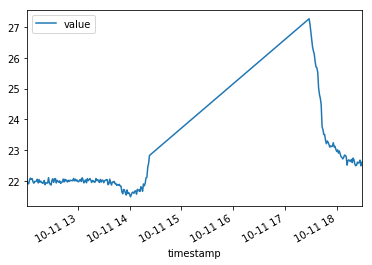

In [22]:
energy_lol = energy_all[energy_all['timestamp'] > '2016-10-11T12:00:00.000000000']
energy_lol = energy_lol[energy_lol['timestamp'] < '2016-10-11T18:30:00.000000000']
energy_lol.head()

energy_lol.plot(x = 'timestamp', y = 'value')

In [28]:
energy_all.head()

,tag,timestamp,value,quality
0,Energy_cons,2016-10-01 00:01:00,20.347507,Good
1,Energy_cons,2016-10-01 00:02:00,20.242380,Good
2,Energy_cons,2016-10-01 00:03:00,20.208391,Good
3,Energy_cons,2016-10-01 00:04:00,20.239189,Good
4,Energy_cons,2016-10-01 00:05:00,20.262808,Good


# Выводы происходят каждую секунду, причем анамалия выше дрежится 4 часа, значит будем смотреть на предудыщие 60, 120, 180 и 240 секунды

In [ ]:
shift_range = [60,120,180,240]

for second_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [85]:
import sklearn.ensemble as ens

In [86]:
energy_dlol = energy_all.drop(['tag', 'quality'], axis = 1)
energy_dlol.head()

,timestamp,value
0,2016-10-01 00:01:00,20.347507
1,2016-10-01 00:02:00,20.242380
2,2016-10-01 00:03:00,20.208391
3,2016-10-01 00:04:00,20.239189
4,2016-10-01 00:05:00,20.262808


In [88]:
energy_all_train = energy_dlol.loc[energy_all['timestamp'] < '2017-08-01T00:01:00.000000000', 'value'].values
energy_all_test = energy_dlol.loc[energy_all['timestamp'] >= '2017-08-01T00:01:00.000000000', 'value'].values

In [89]:
energy_all_test = energy_all_test.reshape(-1,1)
energy_all_train =  energy_all_train.reshape(-1,1)

In [93]:
ens.IsolationForest(n_estimators=100).fit(energy_all_train)
preds = ens.IsolationForest.predict(energy_all_test)

TypeError: unbound method predict() must be called with IsolationForest instance as first argument (got ndarray instance instead)

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = 


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()